In [125]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

train_data = pd.read_csv("../data/titanic/train.csv")
test_data = pd.read_csv("../data/titanic/test.csv")
combine = [train_data, test_data]
train_data.columns.values
# Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.
# Continous: Age, Fare. Discrete: SibSp, Parch.
train_data.info()
print(train_data.describe())
print(train_data.describe(include=['float64','O']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.00000

- Correlating 首先需要分析哪些特征对于是否生存直接相关
- Completing 需要先补齐Age和Embarked，两者都与结果直接相关
- Correcting ticket有大量重复，cabin 有大量的缺失，且与结果不存在关系。passanger id，name与结果不存在关系。
- Creating 生成新的特征，结合parch和sibsp来生成新的特征family，代表有多少家庭人员在船上。处理name特征来生成新的特征title。把年龄特征（连续特征）生成有序分类特征。生成fare区间特征。
- Classifying 增加一些假设：女性，孩子，上层人员（Pclass=1）更有可能生存。
- 协方差矩阵的热图一定程度可以指导哪个变量是重要的
- 统计每个特征的类型和取值范围，数值型特征or类别特征，查看统计信息(describe)
- 可视化每个特征与label之间的关系（例如密度曲线）
- 将类别特征转换为数值型特征。sex转换成0/1，pclass使用get_dummy转换成one-hot编码。
- 填补缺失值
- 构建新的特征（特征工程）
- 评估特征的重要性

In [74]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
#对数据进行分析
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [76]:
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [77]:
train_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [78]:
train_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


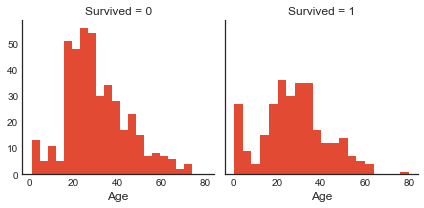

In [79]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

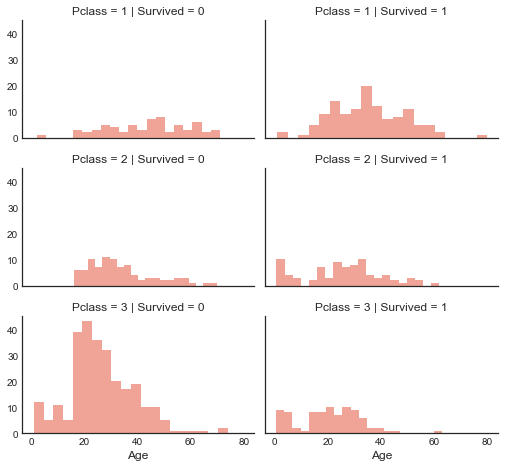

In [80]:
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

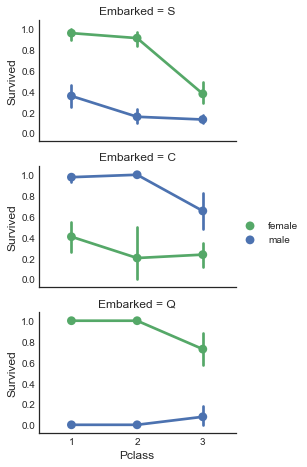

In [81]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_data, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

In [126]:
#删除无用的特征
print("Before", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)

train_data = train_data.drop(['Ticket', 'Cabin'], axis=1)
test_data = test_data.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_data, test_data]

"After", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

In [127]:
#使用name构建新的特征
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
print(pd.crosstab(train_data['Title'], train_data['Sex']))

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [128]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [129]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
#    dataset['Title'] = dataset['Title'].fillna(0)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [130]:
train_data = train_data.drop(['Name', 'PassengerId'], axis=1)
test_data = test_data.drop(['Name'], axis=1)
combine = [train_data, test_data]
train_data.shape, test_data.shape

((891, 9), (418, 9))

In [131]:
#把性别特征转成数值特征
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


- 补充缺失的值
  - 在均值标准差之间生成一个随机值
  - 使用其他特征来猜测（例如取Gendar和Pclass对应的中位数--一般倾向2，因为1，3会引入随机性
  - 结合1和2，例如取Gendar和Pclass对应数据的均值标准差，生成随机值

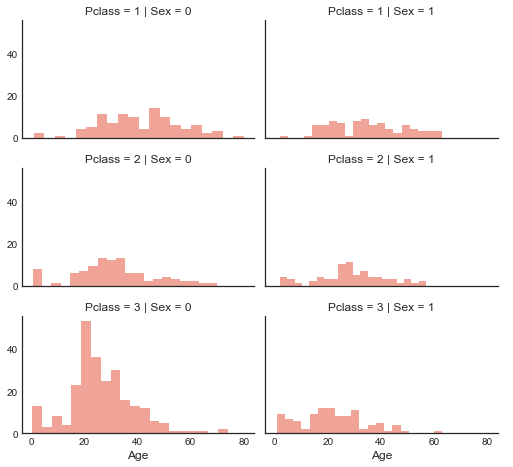

In [132]:
grid = sns.FacetGrid(train_data, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [133]:
#使用方法2填补缺失值
guess_ages = np.zeros((2,3))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [134]:
#把age分成五个区间
train_data['AgeBand'] = pd.cut(train_data['Age'], 5)
train_data[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [113]:
##连续特征转换成类别特征，后续需要再转换成数值型特征
train_data.Fare = train_data.Fare.fillna(-0.5)
bins = (-1, 0, 8, 15, 31, 1000)
group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
categories = pd.cut(train_data.Fare, bins, labels=group_names)
train_data.Fare = categories
test_data.Fare = test_data.Fare.fillna(-0.5)
categories = pd.cut(test_data.Fare, bins, labels=group_names)
test_data.Fare = categories

train_data.Fare.head()

0    1_quartile
1    4_quartile
2    1_quartile
3    4_quartile
4    2_quartile
Name: Fare, dtype: category
Categories (5, object): [Unknown < 1_quartile < 2_quartile < 3_quartile < 4_quartile]

In [114]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train_data, test_data = encode_features(train_data, test_data)
train_data.Fare.head()

0    0
1    3
2    0
3    3
4    1
Name: Fare, dtype: int64

In [135]:
train_data = train_data.drop(['AgeBand'], axis=1)
combine = [train_data, test_data]
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


In [136]:
#创建familysize特征，并删除sibsp和parch特征
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [137]:
#创建isalone特征，代表是否独自一人
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_data[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [138]:
train_data = train_data.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_data = test_data.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_data, test_data]

train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [139]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_data.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [140]:
#补充类别特征embarked特征，使用最高频(mode函数返回最高频率的值)
freq_port = train_data.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [141]:
#把embarked特征也转换成数值型特征
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [142]:
test_data['Fare'].fillna(test_data['Fare'].dropna().median(), inplace=True)
test_data.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [143]:
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
train_data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [144]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_data = train_data.drop(['FareBand'], axis=1)
combine = [train_data, test_data]
    
train_data.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


## 当数据预处理完成后，我们需要选择有意义的特征输入机器学习的算法和模型进行训练。通常来说，从两个方面考虑来选择特征：

特征是否发散：如果一个特征不发散，例如方差接近于0，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用。
特征与目标的相关性：这点比较显见，与目标相关性高的特征，应当优选选择。除移除低方差法外，本文介绍的其他方法均从相关性考虑。
根据特征选择的形式又可以将特征选择方法分为3种：

- Filter：过滤法，按照发散性或者相关性对各个特征进行评分，设定阈值或者待选择阈值的个数，选择特征。
- Wrapper：包装法，根据目标函数（通常是预测效果评分），每次选择若干特征，或者排除若干特征。
- Embedded：嵌入法，先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据系数从大到小选择特征。类似于Filter方法，但是是通过训练来确定特征的优劣。

特征选择主要有两个目的：

- 减少特征数量、降维，使模型泛化能力更强，减少过拟合；
- 增强对特征和特征值之间的理解。
　　
拿到数据集，一个特征选择方法，往往很难同时完成这两个目的。通常情况下，选择一种自己最熟悉或者最方便的特征选择方法（往往目的是降维，而忽略了对特征和数据理解的目的）。本文将结合 Scikit-learn提供的例子 介绍几种常用的特征选择方法，它们各自的优缺点和问题。

#### filter : 
过滤掉方差较小的数据,只能用于离散数据

In [ ]:
from sklearn.feature_selection import VarianceThreshold
X_sample=[[1,2,3],[3,4,3],[5,6,2]]
sel = VarianceThreshold(threshold=(8/3-0.000001))
sel.fit_transform(X_sample)

#### filter : 

单变量特征选择的原理是分别单独的计算每个变量的某个统计指标，根据该指标来判断哪些指标重要，剔除那些不重要的指标。

* 对于分类问题(y离散)，可采用：　
    * 卡方检验，f_classif, mutual_info_classif，互信息
* 对于回归问题(y连续)，可采用：
    * 皮尔森相关系数，f_regression, mutual_info_regression，最大信息系数

单变量特征选择基于单变量的统计测试来选择最佳特征。它可以看作预测模型的一项预处理。==Scikit-learn将特征选择程序用包含 transform 函数的对象来展现==：

SelectKBest 移除得分前 k 名以外的所有特征(取top k)

SelectPercentile 移除得分在用户指定百分比以后的特征(取top k%)

对每个特征使用通用的单变量统计检验： 假正率(false positive rate) SelectFpr, 伪发现率(false discovery rate) SelectFdr, 或族系误差率 SelectFwe.

GenericUnivariateSelect 可以设置不同的策略来进行单变量特征选择。同时不同的选择策略也能够使用超参数寻优，从而让我们找到最佳的单变量特征选择策略。

将特征输入到评分函数，返回一个单变量的f_score(F检验的值)或p-values(P值，假设检验中的一个标准，P-value用来和显著性水平作比较)，注意SelectKBest 和 SelectPercentile只有得分，没有p-value。

* For classification: chi2, f_classif, mutual_info_classif
* For regression: f_regression, mutual_info_regression

F检验用于评估两个随机变量的线性相关性;另一方面，互信息的方法可以捕获任何类型的统计依赖关系，但是作为一个非参数方法，估计准确需要更多的样本).如果你使用稀疏数据(比如，使用稀疏矩阵表示的数据), 卡方检验(chi2)、互信息回归(mutual_info_regression)、互信息分类(mutual_info_classif)在处理数据时可保持其稀疏性.

In [ ]:
#卡方(Chi2)检验
#　　经典的卡方检验是检验定性自变量对定性因变量的相关性。比如，我们可以对样本进行一次chi2 测试来选择最佳的两项特征：

from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_new = SelectKBest(chi2, k=2).fit_transform(X_train, Y_train)
X_new.shape,X_train.shape

In [ ]:
# Pearson相关系数 (Pearson Correlation)
#皮尔森相关系数是一种最简单的，能帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性，结果的取值区间为[-1，1]，-1表示完全的负相关，+1表示完全的正相关，0表示没有线性相关。

#　　Pearson Correlation速度快、易于计算，经常在拿到数据(经过清洗和特征提取之后的)之后第一时间就执行。Scipy的 pearsonr 方法能够同时计算 相关系数 和p-value.

import numpy as np
from scipy.stats import pearsonr
np.random.seed(0)
size = 300
x = np.random.normal(0, 1, size)
# pearsonr(x, y)的输入为特征矩阵和目标向量
print("Lower noise", pearsonr(x, x + np.random.normal(0, 1, size)))
print("Higher noise", pearsonr(x, x + np.random.normal(0, 10, size)))

# 输出为二元组(sorce, p-value)的数组
#Lower noise (0.71824836862138386, 7.3240173129992273e-49)
#Higher noise (0.057964292079338148, 0.31700993885324746)

In [ ]:
#互信息和最大信息系数 (Mutual information and maximal information coefficient (MIC)
#经典的互信息（互信息为随机变量X与Y之间的互信息I(X;Y)为单个事件之间互信息的数学期望）也是评价定性自变量对定性因变量的相关性的，互信息计算公式如下：
#I(X;Y)=E[I(xi;yj)]=∑xiϵX∑yjϵY p(xi,yj)logp(xi,yj)/p(xi)p(yj)

#互信息直接用于特征选择其实不是太方便：1、它不属于度量方式，也没有办法归一化，在不同数据及上的结果无法做比较；2、对于连续变量的计算不是很方便（X和Y都是集合，x，y都是离散的取值），通常变量需要先离散化，而互信息的结果对离散化的方式很敏感。
#最大信息系数克服了这两个问题。它首先寻找一种最优的离散化方式，然后把互信息取值转换成一种度量方式，取值区间在[0，1]。 minepy 提供了MIC功能。
#反过头来看y=x2这个例子，MIC算出来的互信息值为1(最大的取值)。

from minepy import MINE
m = MINE()
x = np.random.uniform(-1, 1, 10000)
m.compute_score(x, x**2)
print(m.mic())

#MIC的统计能力遭到了 一些质疑 ，当零假设不成立时，MIC的统计就会受到影响。在有的数据集上不存在这个问题，但有的数据集上就存在这个问题。



In [ ]:
#距离相关系数 (Distance Correlation)
#距离相关系数是为了克服Pearson相关系数的弱点而生的。在x和x2这个例子中，即便Pearson相关系数是0，我们也不能断定这两个变量是独立的（有可能是非线性相关）；但如果距离相关系数是0，那么我们就可以说这两个变量是独立的。
from scipy.spatial.distance import pdist, squareform
import numpy as np

#from numbapro import jit, float32

def distcorr(X, Y):
    """ Compute the distance correlation function
    
    >>> a = [1,2,3,4,5]
    >>> b = np.array([1,2,9,4,4])
    >>> distcorr(a, b)
    0.762676242417
    """
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    print(a.mean(axis=0)[None, :] , a.mean(axis=1)[:, None])
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    
    dcov2_xy = (A * B).sum()/float(n * n)
    dcov2_xx = (A * A).sum()/float(n * n)
    dcov2_yy = (B * B).sum()/float(n * n)
    dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
    return dcor


x = np.random.uniform(-1,1,5)
y = np.random.uniform(-1,1,5)
distcorr(x, y)
#尽管有 MIC 和 距离相关系数 在了，但当变量之间的关系接近线性相关的时候，Pearson相关系数仍然是不可替代的。
#第一，Pearson相关系数计算速度快，这在处理大规模数据的时候很重要。
#第二，Pearson相关系数的取值区间是[-1，1]，而MIC和距离相关系数都是[0，1]。这个特点使得Pearson相关系数能够表征更丰富的关系，符号表示关系的正负，绝对值能够表示强度。当然，Pearson相关性有效的前提是两个变量的变化关系是单调的。

In [ ]:
#基于模型的特征排序 (Model based ranking)
#这种方法的思路是直接使用你要用的机器学习算法，针对 每个单独的特征 和 响应变量建立预测模型。假如 特征 和 响应变量 之间的关系是非线性的，可以用基于树的方法(决策树、随机森林)、或者 扩展的线性模型 等。基于树的方法比较易于使用，因为他们对非线性关系的建模比较好，并且不需要太多的调试。但要注意过拟合问题，因此树的深度最好不要太大，再就是运用交叉验证。
#在波士顿房价数据集 上使用sklearn的 随机森林回归 给出一个_单变量选择_的例子(这里使用了交叉验证)：

from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Load boston housing dataset as an example
boston = load_boston()
X = boston["data"]
Y = boston["target"]
names = boston["feature_names"]

rf = RandomForestRegressor(n_estimators=20, max_depth=4)
scores = []
# 单独采用每个特征进行建模，并进行交叉验证
for i in range(X.shape[1]):
    score = cross_val_score(rf, X[:, i:i+1], Y, scoring="r2",  # 注意X[:, i]和X[:, i:i+1]的区别
                            cv=ShuffleSplit(len(X), 3, .3))
    scores.append((format(np.mean(score), '.3f'), names[i]))
print(sorted(scores, reverse=True))

### Embedded

使用SelectFromModel选择特征 (Feature selection using SelectFromModel)
   
单变量特征选择方法独立的衡量每个特征与响应变量之间的关系，另一种主流的特征选择方法是基于机器学习模型的方法。有些机器学习方法本身就具有对特征进行打分的机制，或者很容易将其运用到特征选择任务中，例如回归模型，SVM，决策树，随机森林等等。其实Pearson相关系数等价于线性回归里的标准化回归系数。

SelectFromModel 作为meta-transformer，能够用于拟合后任何拥有coef_或feature_importances_ 属性的预测模型。 如果特征对应的coef_ 或 feature_importances_ 值低于设定的阈值threshold，那么这些特征将被移除。除了手动设置阈值，也可通过字符串参数调用内置的启发式算法(heuristics)来设置阈值，包括：平均值(“mean”), 中位数(“median”)以及他们与浮点数的乘积，如”0.1*mean”。

In [ ]:
#基于L1的特征选择 (L1-based feature selection)
#使用L1范数作为惩罚项的线性模型(Linear models)会得到稀疏解：大部分特征对应的系数为0。当你希望减少特征的维度以用于其它分类器时，可以通过 feature_selection.SelectFromModel 来选择不为0的系数。特别指出，常用于此目的的稀疏预测模型有 linear_model.Lasso（回归）， linear_model.LogisticRegression 和 svm.LinearSVC（分类）:

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
iris = load_iris()
X, y = iris.data, iris.target
X.shape

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
#带L1和L2惩罚项的逻辑回归作为基模型的特征选择
#参数threshold为权值系数之差的阈值

X_new = SelectFromModel(LogisticRegression(C=0.2)).fit_transform(iris.data, iris.target)
X_new.shape

### L1恢复和压缩感知 (L1-recovery and compressive sensing)
　　对于一个好的alpha值，在满足特定条件下， Lasso 仅使用少量观测值就能够完全恢复出非零的系数。特别地，样本的数量需要“足够大”，否则L1模型的表现会充满随机性，所谓“足够大”取决于非零系数的数量，特征数量的对数，噪声的数量，非零系数的最小绝对值以及设计矩阵X的结构。此外，设计矩阵必须拥有特定的属性，比如不能太过相关(correlated)。 对于非零系数的恢复，还没有一个选择alpha值的通用规则 。alpha值可以通过交叉验证来设置(LassoCV or LassoLarsCV)，尽管这也许会导致模型欠惩罚(under-penalized)：引入少量非相关变量不会影响分数预测。相反BIC (LassoLarsIC) 更倾向于设置较大的alpha值。
  
  对于SVM和逻辑回归，参数C控制稀疏性：C越小，被选中的特征越少。对于Lasso，参数alpha越大，被选中的特征越少。
  

In [ ]:
#基于树的特征选择 (Tree-based feature selection)
#　　基于树的预测模型（见 sklearn.tree 模块，森林见 sklearn.ensemble 模块）能够用来计算特征的重要程度，因此能用来去除不相关的特征（结合 sklearn.feature_selection.SelectFromModel）:

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
iris = load_iris()
X, y = iris.data, iris.target
X.shape
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

#### 随机稀疏模型 (Randomized sparse models)
+ 基于L1的稀疏模型的局限在于，当面对一组互相关的特征时，它们只会选择其中一项特征。为了减轻该问题的影响可以使用随机化技术，通过_多次重新估计稀疏模型来扰乱设计矩阵_，或通过_多次下采样数据来统计一个给定的回归量被选中的次数_。——==稳定性选择 (Stability Selection)==
  + RandomizedLasso 实现了使用这项策略的Lasso，RandomizedLogisticRegression 使用逻辑回归，适用于分类任务。要得到整个迭代过程的稳定分数，你可以使用 lasso_stability_path。
  + 注意到对于非零特征的检测，要使随机稀疏模型比标准F统计量更有效， 那么模型的参考标准需要是稀疏的，换句话说，非零特征应当只占一小部分。

In [ ]:
#将特征选择过程融入pipeline (Feature selection as part of a pipeline)
#　　特征选择常常被当作学习之前的一项预处理。在scikit-learn中推荐使用
from sklearn.pipeline import Pipeline

clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

<table>
<tr><td>类</td>	<td>所属方式</td>	<td>说明</td></tr>
    <tr><td>VarianceThreshold</td>	<td>Filter</td>	<td>方差选择法(移除低方差的特征)</td></tr>
<tr><td>SelectKBest</td>	<td>Filter</td>	<td>可选关联系数、卡方校验、最大信息系数作为得分计算的方法</td></tr>
<tr><td>RFE</td>	<td>Wrapper</td>	<td>递归地训练基模型，将权值系数较小的特征从特征集合中消除</td></tr>
<tr><td>SelectFromModel</td>	<td>Embedded</td>	<td>训练基模型，选择权值系数较高的特征</td></tr>
</table>


| 包                 | 类或方法 | 说明                     |
| ------------------- | ------------ | -------------------------- |
| sklearn.pipeline    | Pipeline     | 流水线处理            |
| sklearn.pipeline    | FeatureUnion | 并行处理               |
| sklearn.grid_search | GridSearchCV | 网格搜索自动化调参 |
| externals.joblib    | dump         | 数据持久化            |
| externals.joblib    | load         | 从文件系统中加载数据至内存 |

# 数据处理部分结束了，可以开始构建模型了
- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forrest
- Perceptron
- Artificial neural network
- RVM or Relevance Vector Machine

In [145]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [ ]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(acc_log)
coeff_df = pd.DataFrame(train_data.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

In [ ]:
#svm 非概率二元分类器
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

In [ ]:
#knn
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

In [ ]:
#naive bayes 基于强烈的特征之间的独立性假设
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

In [ ]:
#perceptron 是一种线性分类器，可支持在线学习，对训练集的数据只处理一次
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

In [ ]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

In [ ]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

In [146]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

### Fitting and Tuning an Algorithm

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, Y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# 模型评价

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('../data/titanic/submission.csv', index=False)

In [ ]:
##自动选择最优的特征
rfecv = RFECV( estimator = random_forest , step = 1 , cv = StratifiedKFold( Y_train , 2 ) , scoring = 'accuracy' )
rfecv.fit( X_train , Y_train )
print (rfecv.score( X_train , Y_train ) )
print( "Optimal number of features : %d" % rfecv.n_features_ )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel( "Number of features selected" )
plt.ylabel( "Cross validation score (nb of correct classifications)" )
plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
plt.show()

In [150]:
##K折交叉验证

from sklearn.cross_validation import KFold

X_all,y_all = X_train,Y_train
def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)


Fold 1 accuracy: 0.7666666666666667
Fold 2 accuracy: 0.8426966292134831
Fold 3 accuracy: 0.7640449438202247
Fold 4 accuracy: 0.8539325842696629
Fold 5 accuracy: 0.8426966292134831
Fold 6 accuracy: 0.797752808988764
Fold 7 accuracy: 0.797752808988764
Fold 8 accuracy: 0.7303370786516854
Fold 9 accuracy: 0.8426966292134831
Fold 10 accuracy: 0.8089887640449438
Mean Accuracy: 0.8047565543071162
